In [25]:
import numpy as np
import pandas as pd
import h5py
from matplotlib import pyplot as plt
from scipy.signal.windows import tukey

from tqdm import tqdm 
from glob import glob

import os
import wget
from gwosc.timeline import get_segments
from gwosc.locate import get_urls

import requests
import json

In [7]:
# define the instrument we want ('H1' for Hanford, 'L1' for Livingston)
ifo = 'H1'
data_dir = 'bulk_data'

In [2]:
def read_data(path, **kws):
    with h5py.File(path, 'r') as f:
        t0 = f['meta/GPSstart'][()]
        T = f['meta/Duration'][()]
        h = f['strain/Strain'][:]
        dt = T/len(h)
        time = t0 + dt*np.arange(len(h))
        return pd.Series(h, index=time, **kws)

In [5]:
data_list = []
for path in tqdm(sorted(glob(os.path.join(data_dir, '*.hdf5')))):
    data_list.append(read_data(path))

  2%|▏         | 17/783 [00:24<18:19,  1.44s/it]


KeyboardInterrupt: 

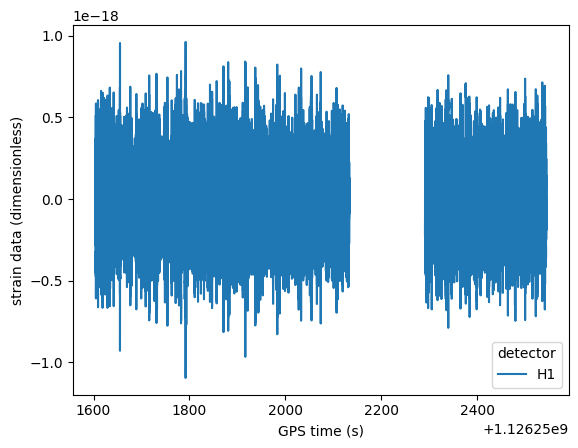

In [8]:
d = data_list[0]
epoch = d.index[0]
plt.plot(d, label=ifo)
plt.legend(title="detector", loc="lower right")
plt.xlabel("GPS time (s)")
plt.ylabel("strain data (dimensionless)");

In [9]:
d

1.126248e+09             NaN
1.126248e+09             NaN
1.126248e+09             NaN
1.126248e+09             NaN
1.126248e+09             NaN
                    ...     
1.126253e+09   -1.962237e-20
1.126253e+09   -1.357275e-20
1.126253e+09   -2.460189e-20
1.126253e+09   -6.847398e-20
1.126253e+09   -2.896389e-20
Length: 16777216, dtype: float64

In [10]:
# duration of segment in seconds
T = 4

data_segments = []
for d in tqdm(data_list):
    # sampling interval
    dt = d.index[1] - d.index[0]
    # segment length
    N = int(round(T / dt))
    # number of segments
    N_segments = int(len(d) / N)
    data_segments += [d.iloc[k*N:k*N+N] for k in range(N_segments)]

100%|██████████| 17/17 [00:00<00:00, 46.06it/s]


In [13]:
print(dt)

0.000244140625


In [14]:
print(f"There are {len(data_segments)} {ifo} segments.")

There are 17408 H1 segments.


In [18]:
# get detection catalog from GWOSC
# url = 'https://www.gw-openscience.org/eventapi/jsonfull/GWTC/'
# with requests.get(url) as r:
#     rjson = r.json()

filename = 'gwosc_catalog.json'  # specify the filename of the JSON file

with open(filename, 'r') as file:
    rjson = json.load(file)

true_event_times = sorted([v['GPS'] for v in rjson['events'].values()])

In [21]:
data_segments[10].shape

(16384,)

In [22]:
good_segments = []
#good_segments = np.zeros((len(data_segments), data_segments[0].shape[0]))
for s in tqdm(data_segments):
    no_events = all([(t0 < s.index[0] or t0 > s.index[-1]) for t0 in true_event_times])
    no_nans = not s.isnull().values.any()
    if no_events and no_nans:
        good_segments.append(s)

print(f"There are {len(good_segments)} good {ifo} segments.")

100%|██████████| 17408/17408 [00:01<00:00, 9216.17it/s]

There are 13869 good H1 segments.


In [26]:
def get_data_fd(d):
  tukey_alpha = 0.1
  Nsize = d.shape[0]
  w = tukey(Nsize, tukey_alpha)
  f = np.fft.rfftfreq(Nsize, d=dt)
  data_fd = pd.Series(np.fft.rfft(d*w)*dt, index=f)
  return data_fd, f, dt

def preprocess_data(data_fd, hz_cut=20, rescale_factor=1e-23):
  f = np.array(data_fd.index)
  amp = np.array(data_fd.array)
  amp[f < hz_cut] = 0.
  return amp[1:]/rescale_factor # Remove zero frequency to make resolution 8192 instead of 8193 and rescale data by constant

def get_training_data(segments):
  training_data = []
  for segment in segments:
    data_fd, f, dt = get_data_fd(segment)
    data = preprocess_data(data_fd, hz_cut=20., rescale_factor=1e-23)
    data = np.array([data.real, data.imag]).astype('float32')
    training_data.append(data)
  return np.array(training_data)

In [27]:
training_data = get_training_data(good_segments)

In [28]:
h5f = h5py.File('trainH_bulk_2month.h5', 'w')
h5f.create_dataset('data', data=training_data)
h5f.close()